# Baseline Forecast

In [160]:
import sys
sys.path.append('/Users/nayeongkim/Desktop/HKweather/')
print(sys.path)
import pandas as pd
import seaborn as sns
from functions.eval import evaluate_performance
from functions import ts_utils
from functions.plot_functions import plot_forecast
from functions.plot_functions import format_plot
from functions.forecast_bs import NaiveMovingAverage

['/Users/nayeongkim/miniconda3/envs/HKweather3.9/lib/python39.zip', '/Users/nayeongkim/miniconda3/envs/HKweather3.9/lib/python3.9', '/Users/nayeongkim/miniconda3/envs/HKweather3.9/lib/python3.9/lib-dynload', '', '/Users/nayeongkim/miniconda3/envs/HKweather3.9/lib/python3.9/site-packages', '/Users/nayeongkim/miniconda3/envs/HKweather3.9/lib/python3.9/site-packages/setuptools/_vendor', '/Users/nayeongkim/Desktop/HKweather/', '/Users/nayeongkim/Desktop/HKweather/', '/Users/nayeongkim/Desktop/HKweather/', '/Users/nayeongkim/Desktop/HKweather/', '/Users/nayeongkim/Desktop/HKweather/', '/Users/nayeongkim/Desktop/HKweather/', '/Users/nayeongkim/Desktop/HKweather/']


In [161]:
daily_temp_train = pd.read_parquet("../0_Data/wrangled/daily_temp_train.parquet")
daily_temp_val = pd.read_parquet("../0_Data/wrangled/daily_temp_val.parquet")
daily_temp_test = pd.read_parquet("../0_Data/wrangled/daily_temp_test.parquet")

In [162]:
# Data Frequency setting
freq = "D" # daily frequency (not even the business day frequency)

In [163]:
daily_temp_train.reset_index(inplace = True)
daily_temp_test.reset_index(inplace = True)
daily_temp_val.reset_index(inplace = True)

In [164]:
daily_temp_train.rename(columns = {'Date':'ds'}, inplace = True)
daily_temp_test.rename(columns = {'Date':'ds'}, inplace = True)
daily_temp_val.rename(columns = {'Date':'ds'}, inplace = True)

In [165]:
pred_df = pd.concat([daily_temp_train, daily_temp_val])

In [166]:
from statsforecast import StatsForecast
from utilsforecast.evaluation import evaluate
from statsforecast.models import (
    Naive,
    SeasonalNaive,
    HistoricAverage,
    WindowAverage,
    SeasonalWindowAverage,
    RandomWalkWithDrift,
    HoltWinters,
    ETS,
    AutoETS,
    AutoARIMA,
    #ARIMA,
    AutoTheta,
    DynamicTheta,
    DynamicOptimizedTheta,
    Theta,
    OptimizedTheta,
    #TBATS,
    #AutoTBATS,
    MSTL
)

## (1) Explored Baseline models

- **Naïve forecast**: Proposing the last/most recent observation in a time series as a forecast

- **Moving average forecast**: A moving average forecast is another simple method that tries to overcome the pure memorization of the naïve method. Instead of taking the latest observation, it takes the mean of the latest *n* steps as the forecast.

- **Exponential smoothing**: ETS combines both these intuitions and says that all the history is important, but the recent history is more important. Therefore, the forecast is generated using a weighted average where the weights decrease exponentially as we move farther into the history

In [167]:
daily_temp_train.tail(1)

,ds,y,unique_id
3652,2024-12-31,23.454054,1.0


- **Naive forecast**

In [168]:
daily_temp_train

,ds,y,unique_id
0,2015-01-01,20.161111,1.0
1,2015-01-02,17.941667,1.0
2,2015-01-03,19.447222,1.0
3,2015-01-04,21.361111,1.0
4,2015-01-05,21.580556,1.0
...,...,...,...
3648,2024-12-27,21.005405,1.0
3649,2024-12-28,19.089189,1.0
3650,2024-12-29,18.137838,1.0
3651,2024-12-30,22.337838,1.0


In [169]:
from functions.ts_utils import mase, mae, mse, forecast_bias

metrics = pd.DataFrame()

results, metrics = evaluate_performance(
    ts_train=daily_temp_train, 
    ts_test=daily_temp_val, 
    models=[Naive()], 
    metrics=[mase, mae, mse, forecast_bias], 
    freq=freq,
    level=[],  # Ensure this is correct or adjust as necessary
    id_col='unique_id',
    time_col='ds',
    target_col='y',
    h=len(daily_temp_val),
    metric_df=metrics  # Pass None or an existing DataFrame if you want to append results
)

             ds          y  unique_id
0    2015-01-01  20.161111        1.0
1    2015-01-02  17.941667        1.0
2    2015-01-03  19.447222        1.0
3    2015-01-04  21.361111        1.0
4    2015-01-05  21.580556        1.0
...         ...        ...        ...
3648 2024-12-27  21.005405        1.0
3649 2024-12-28  19.089189        1.0
3650 2024-12-29  18.137838        1.0
3651 2024-12-30  22.337838        1.0
3652 2024-12-31  23.454054        1.0

[3653 rows x 3 columns]
           ds          y  unique_id      Naive
0  2025-01-01  18.405405        1.0  23.454054
1  2025-01-02  22.029730        1.0  23.454054
2  2025-01-03  21.448649        1.0  23.454054
3  2025-01-04  20.354054        1.0  23.454054
4  2025-01-05  22.477778        1.0  23.454054
5  2025-01-06  22.300000        1.0  23.454054
6  2025-01-07  19.862162        1.0  23.454054
7  2025-01-08  21.464865        1.0  23.454054
8  2025-01-09  21.116216        1.0  23.454054
9  2025-01-10  17.316216        1.0  23.454054
10

/Users/nayeongkim/miniconda3/envs/HKweather3.9/lib/python3.9/site-packages/numpy/core/numeric.py:330: RuntimeWarning:

invalid value encountered in cast



In [170]:
results.head()

,ds,y,unique_id,Naive
0,2025-01-01,18.405405,1.0,23.454054
1,2025-01-02,22.029730,1.0,23.454054
2,2025-01-03,21.448649,1.0,23.454054
3,2025-01-04,20.354054,1.0,23.454054
4,2025-01-05,22.477778,1.0,23.454054


In [171]:
metrics_agg = metrics

In [172]:
model_name = ['Naive']
model_display_name = ['Naive']

fig = plot_forecast(results, forecast_columns=model_name, forecast_display_names=model_display_name, timestamp_col ='ds')
fig = format_plot(fig, title=f"{model_name[0]}: "\
                  f"MAE: {metrics.loc[metrics.Model==model_name[0]][['mae']].iloc[0].item():.4f} | "\
                  f"MASE: {metrics.loc[metrics.Model==model_name[0]][['mase']].iloc[0].item():.4f} | "\
                  f"BIAS: {metrics.loc[metrics.Model==model_name[0]][['forecast_bias']].iloc[0].item():.4f}")
fig

- **Moving Average smoothing**

In [ ]:
from darts import TimeSeries
train_TS = TimeSeries.from_dataframe(daily_temp_train, time_col = "ds", value_cols="y")
naive_model = NaiveMovingAverage(window=48)
naive_model.fit(train_TS)
pred_MA = naive_model.predict(31)
results['bs_MA'] = pred_MA.univariate_values()

model_name = ['bs_MA']
model_display_name = ['bs_MA']

In [175]:
id_col = 'unique_id'
target_col = 'y'
model_name = 'bs_MA'
ids = daily_temp_val[id_col].unique()
metrics = [mase, mae, mse, forecast_bias]
evaluation = {} 
metric_df = pd.DataFrame()

# Calculate metrics

for id in ids:
    
    temp_results = results[results[id_col] == id]
    temp_train = daily_temp_train[daily_temp_train[id_col] == id]

    for metric in metrics:
        metric_name = metric.__name__
        if metric_name == 'mase':
            evaluation[metric_name] = metric(temp_results[target_col].values,
                                             temp_results[model_name].values,
                                             temp_train[target_col].values)
        else:
            evaluation[metric_name] = metric(temp_results[target_col].values, temp_results[model_name].values)
    evaluation[id_col] = id

    # Prepare and append this model's results to metric_df
    temp_df = pd.DataFrame(evaluation, index=[0])
    temp_df['Model'] = model_name
    metric_df = pd.concat([metric_df, temp_df], ignore_index=True)

In [ ]:
metrics_agg = pd.concat([metrics_agg, metric_df], ignore_index=True)

In [178]:
model_name = ['bs_MA']
model_display_name = ['bs_MA']

fig = plot_forecast(results, 
                    forecast_columns=model_name, 
                    forecast_display_names=model_display_name,
                    timestamp_col ='ds')

In [181]:
fig = format_plot(fig, title=f"{model_name[0]}: "\
                  f"MAE: {metric_df.loc[metric_df.Model==model_name[0]][['mae']].iloc[0].item():.4f} | "\
                  f"MASE: {metric_df.loc[metric_df.Model==model_name[0]][['mase']].iloc[0].item():.4f} | "\
                  f"BIAS: {metric_df.loc[metric_df.Model==model_name[0]][['forecast_bias']].iloc[0].item():.4f}")
fig

- **SNAIVE forecast model with annual seasonality**

In [215]:
Snaive_model = SeasonalNaive(365)
Snaive_model.fit(daily_temp_train['y'].values)
pred_SNAIVE = Snaive_model.predict(31)

results['bs_SNAIVE'] = pred_SNAIVE['mean']

model_name = ['bs_SNAIVE']
model_display_name = ['bs_SNAIVE']

In [221]:
id_col = 'unique_id'
target_col = 'y'
model_name = 'bs_SNAIVE'
ids = daily_temp_val[id_col].unique()
metrics = [mase, mae, mse, forecast_bias]
evaluation = {} 
metric_df = pd.DataFrame()

# Calculate metrics

for id in ids:
    
    temp_results = results[results[id_col] == id]
    temp_train = daily_temp_train[daily_temp_train[id_col] == id]

    for metric in metrics:
        metric_name = metric.__name__
        if metric_name == 'mase':
            evaluation[metric_name] = metric(temp_results[target_col].values,
                                             temp_results[model_name].values,
                                             temp_train[target_col].values)
        else:
            evaluation[metric_name] = metric(temp_results[target_col].values, temp_results[model_name].values)
    evaluation[id_col] = id

    # Prepare and append this model's results to metric_df
    temp_df = pd.DataFrame(evaluation, index=[0])
    temp_df['Model'] = model_name
    metric_df = pd.concat([metric_df, temp_df], ignore_index=True)

metrics_agg = pd.concat([metrics_agg, metric_df], ignore_index=True)

- **Exponential smoothing**

In [244]:
from statsforecast.models import (SimpleExponentialSmoothing, Holt, HoltWinters, AutoETS)
exp_smooth = AutoETS(model = "ZZZ", season_length = 24)
exp_smooth.fit(daily_temp_train['y'].values)

exp_smooth2 = HoltWinters(error_type = 'A', season_length = 14)
exp_smooth2.fit(daily_temp_train['y'].values)

pred_ETS = exp_smooth2.predict(31)

results['bs_ETS'] = pred_ETS['mean']
model_name = ['bs_ETS']
model_display_name = ['bs_ETS']

## (2) Forecast comparison using different basic models

In [245]:
rst_groupe = results.drop(labels = ['unique_id'],
                          axis = 1)

rst_groupe = rst_groupe.melt(id_vars = "ds")
#rst_groupe.set_index('ds', inplace = True)
rst_groupe.head()


,ds,variable,value
0,2025-01-01,y,18.405405
1,2025-01-02,y,22.029730
2,2025-01-03,y,21.448649
3,2025-01-04,y,20.354054
4,2025-01-05,y,22.477778


/var/folders/6b/16jtbq3j6w17kqv1h2k9_zt80000gn/T/ipykernel_39211/2883962204.py:2: UserWarning:

The palette list has more values (6) than needed (5), which may not be intended.



[Text(0.5, 0, '2025'), Text(0, 0.5, 'Temperature (C)')]

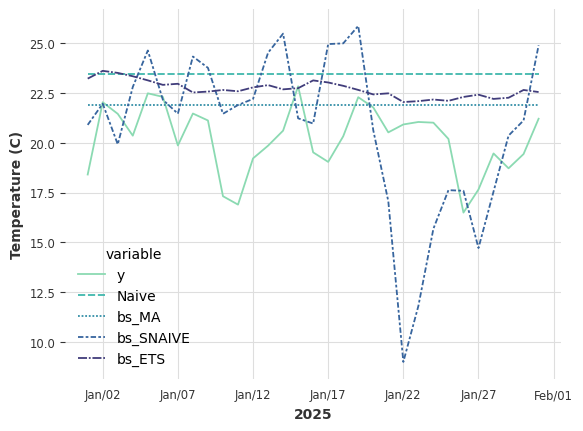

In [246]:
palette = sns.color_palette("mako_r", 6)
ax = sns.lineplot(data=rst_groupe, x="ds", y="value",
             hue="variable",
             style = "variable",
             palette=palette)

import matplotlib.dates as mdates
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b/%d'))
ax.set(xlabel = "2025", ylabel = "Temperature (C)")